# 1. Cài đặt các thư viện cần thiết

In [526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import math
import warnings
warnings.filterwarnings("ignore")

# 2. Tải bộ dữ liệu thời tiết

In [527]:
data = pd.read_csv("/kaggle/input/weather/6. Weather.csv")

# 3. Phân tích dữ liệu

## 3.1 Ý nghĩa của từng trường thông tin

In [528]:
data

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


* Nhìn chung, dataset bao gồm 13200 dòng và 11 cột chứa các thông tin thời tiết tại nhiều địa điểm, mùa khác nhau.
* Các đặc trưng thời tiết trong bộ dataset:
1. Temperature: Nhiệt độ (°C)
2. Humidity: Phần trăm độ ẩm (%)
3. Wind Speed: Tốc độ gió (km/h)
4. Precipitation (%): Tỷ lệ phần trăm mưa (%)
5. Cloud Cover: Độ che phủ của mây
6. Atmospheric Pressure: Áp suất khí quyển tính bằng hPa, bao phủ một phạm vi rộng
7. UV Index: Chỉ số UV, biểu thị cường độ của bức xạ tím
8. Season: Mùa mà dữ liệu được ghi lại
9. Visibility (km): Tầm nhìn xa (km)
10. Location: Loại vị trí mà dữ liệu được ghi lại
11. Weather Type: Loại thời tiết

In [529]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [530]:
data.isnull().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

=> Tất cả các cột đều đầy đủ (non-null = 13200) như vậy ta không cần xử lý giá trị thiếu.

In [531]:
data.duplicated().sum()

0

=> Không có giá trị trùng lặp

In [532]:
data.nunique()

Temperature              126
Humidity                  90
Wind Speed                97
Precipitation (%)        110
Cloud Cover                4
Atmospheric Pressure    5456
UV Index                  15
Season                     4
Visibility (km)           41
Location                   3
Weather Type               4
dtype: int64

In [533]:
def check_special_values(data):
    nan_values = data.isna()
    inf_values = (data == np.inf) | (data == -np.inf)
    special_values = (data == 9999) | (data == -9999)
    if nan_values.any().any() or inf_values.any().any() or special_values.any().any():
        print("Dữ liệu chứa giá trị đặc biệt: NaN, inf, -inf hoặc 9999")
        if nan_values.any().any():
            print("Các giá trị NaN có trong các vị trí sau:")
            print(data[nan_values].dropna(how='all'))
        if inf_values.any().any():
            print("Các giá trị inf hoặc -inf có trong các vị trí sau:")
            print(data[inf_values].dropna(how='all'))
        if special_values.any().any():
            print("Các giá trị 9999 có trong các vị trí sau:")
            print(data[special_values].dropna(how='all'))
    else:
        print("Dữ liệu không chứa giá trị đặc biệt (NaN, inf, -inf, 9999, -9999).")
check_special_values(data)

Dữ liệu không chứa giá trị đặc biệt (NaN, inf, -inf, 9999, -9999).


In [534]:
category = data.select_dtypes(include=object).columns.tolist()
numeric = data.select_dtypes(exclude=object).columns.tolist()
print('categorical_columns: ' ,category)
print('numerical_columns: ' , numeric)

categorical_columns:  ['Cloud Cover', 'Season', 'Location', 'Weather Type']
numerical_columns:  ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']


Như vậy, bộ dataset gồm:
1. Các biến số (numerical features): Temperature, Humidity, Wind Speed, Precipitation (%), Atmospheric Pressure, UV Index, Visibility (km)

2. Các biến phân loại (categorical features): Cloud Cover, Season, Location, Weather Type

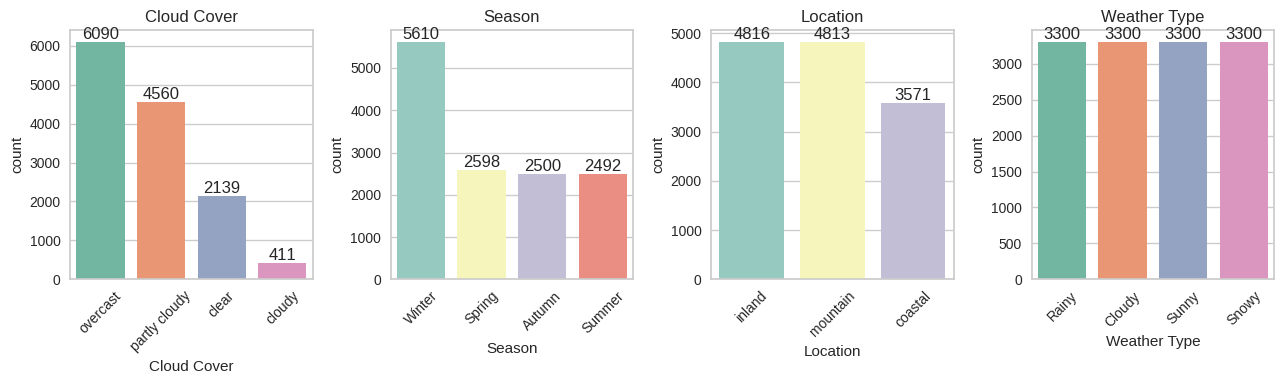

In [535]:
plt.figure(figsize=(13, 4)) 
# Cloud Cover
plt.subplot(1, 4, 1)
ax = sns.countplot(x=data['Cloud Cover'], order=data['Cloud Cover'].value_counts(ascending=False).index, palette='Set2')
abs_values = data['Cloud Cover'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.xlabel("Cloud Cover")
plt.title("Cloud Cover")
plt.xticks(rotation=45)
# Season
plt.subplot(1, 4, 2)
ax1 = sns.countplot(x=data['Season'], order=data['Season'].value_counts(ascending=False).index, palette='Set3')
abs1_values = data['Season'].value_counts(ascending=False).values
ax1.bar_label(container=ax1.containers[0], labels=abs1_values)
plt.xlabel("Season")
plt.title("Season")
plt.xticks(rotation=45)
# Location
plt.subplot(1, 4, 3)
ax2 = sns.countplot(x=data['Location'], order=data['Location'].value_counts(ascending=False).index, palette='Set3')
abs2_values = data['Location'].value_counts(ascending=False).values
ax2.bar_label(container=ax2.containers[0], labels=abs2_values)
plt.xlabel("Location")
plt.title("Location")
plt.xticks(rotation=45)
# Weather Type
plt.subplot(1, 4, 4)
ax3 = sns.countplot(x=data['Weather Type'], order=data['Weather Type'].value_counts(ascending=False).index, palette='Set2')
abs3_values = data['Weather Type'].value_counts(ascending=False).values
ax3.bar_label(container=ax3.containers[0], labels=abs3_values)
plt.xlabel("Weather Type")
plt.title("Weather Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Cloud Cover: phân bố không đều. Overcast: Chiếm nhiều nhất khoảng 6090 dòng. Partly Cloudy: Khá nhiều khoảng 4560 dòng. Clear: Ít hơn khoảng 2139 dòng. Cloudy: Số lượng rất ít khoảng 411 dòng.
2. Season: Winter: Áp đảo với 5610 dòng, hơn 40%. Các mùa khác Spring, Autumn, Summer gần như đồng đều khoảng 2500 dòng mỗi mùa.
3. Location: Inland và Mountain: Số lượng gần bằng nhau (khoảng 4816 và 4813). Coastal: Ít hơn khoảng 3571 dòng.
4. Weather Type: Phân bố cân đối, mỗi loại đều đúng bằng nhau (3300 dòng).

## 3.2 Một vài thống kê

Ở mỗi trường thông tin, các thống kê được chỉ ra cho các giá trị không bị khuyết trong trường đó là:


* count: số lượng phần tử không bị khuyết,
* mean: giá trị trung bình,
* std: phương sai,
* min: giá trị nhỏ nhất,
* max: giá trị lớn nhất,
* 50% (Q2): trung vị – giá trị mà ở đó có đúng một nửa số phần tử trong cột có giá trị nhỏ hơn hoặc bằng nó.
* 25% (Q1): trung vị của các giá trị từ min tới 50%, tức có đúng 25% số phần tử trong cột có giá trị nhỏ hơn hoặc bằng nó,
* 75% (Q3): trung vị của các giá trị từ 50% tới max, tức có đúng 75% số phần tử trong cột có giá trị nhỏ hơn hoặc bằng nó,


In [536]:
data.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


Dữ liệu đầy đủ, không có giá trị thiếu (count = 13200 cho mọi trường).
1. Temperature: Trung bình 19.13°C, độ lệch chuẩn lớn (17.39°C), phân phối rộng từ -25°C đến 109°C. Nhiệt độ cực cao bất thường (>50°C) → cần kiểm tra outliers.
2. Humidity:Trung bình 68.71%, phân phối đồng đều, min 20%, max 109% (vượt ngưỡng vật lý).
Cần xử lý giá trị >100%.
3. Wind Speed:Trung bình 9.83 km/h, lệch phải nhẹ, max 48.5 km/h (gió mạnh hợp lý). Không cần xử lý thêm.
4. Precipitation (%): Trung bình 53.64%, min 0%, max 109% (bất hợp lý). Cần kiểm tra và xử lý các giá trị >100%.
5. Atmospheric Pressure: Trung bình 1005.83 hPa, giá trị dao động từ 800.12 hPa đến 1199.21 hPa. Các giá trị cực thấp/cao có thể là lỗi → cần xác minh.
6. UV Index: Trung bình 4.01, phân phối lệch phải, max 14. Phân phối hợp lý, không thấy outlier.
7. Visibility (km): Trung bình 5.46 km, từ 0 đến 20 km. Phân phối tự nhiên, hợp lý theo thời tiết.

## 3.3 Minh họa histogram và KDE

Qua các thống kê count, min, max, Q1, Q2, Q3, std, mean ở phía trước, để hình dung rõ phân phối của các biến ta minh họa các histogram như sau:

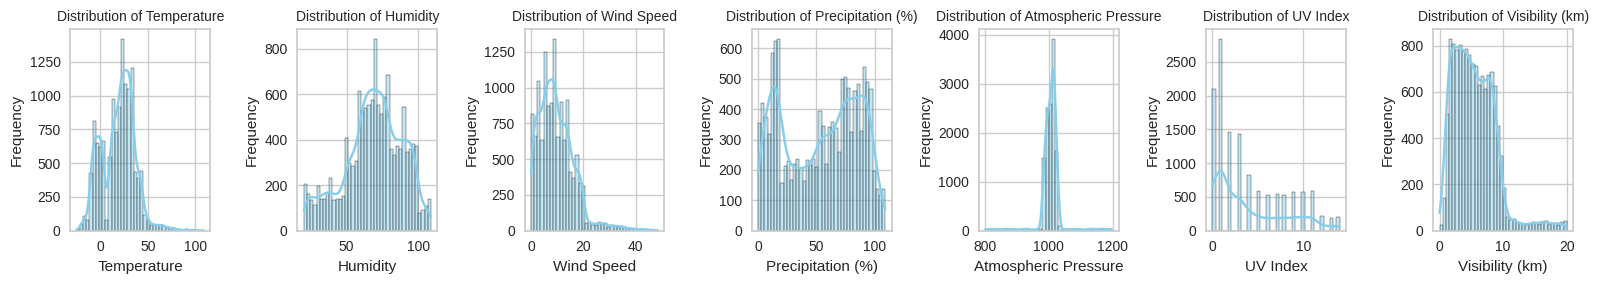

In [537]:
numeric = data.select_dtypes(exclude='object').columns.tolist()
num_cols = len(numeric)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(16, 3))
for i, col in enumerate(numeric):
    ax = axes[i]
    sns.histplot(data[col], kde=True, bins=40, color='skyblue', ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(True)
plt.tight_layout()
plt.show()

Qua các histogram, ta thấy rõ được phân phối của các biến như đã nói trước đó:
* Temperature: phân phối không đối xứng, lệch phải; có 2 đỉnh: 1 đỉnh thấp (khoảng 0°C) và 1 đỉnh cao (khoảng 25–30°C); có vài giá trị cao bất thường (khoảng >60°C), không thực tế.
* Humidity: phân phối khá chuẩn, tập trung nhiều ở khoảng 60–90%, có nhiều đỉnh nhỏ. Một vài giá trị vượt 100% sẽ bị loại bỏ.
* Wind Speed: phân phối lệch phải rõ rệt. Nhiều giá trị thấp (0–10 km/h), nhưng có vài đỉnh cao >40 km/h — có thể xem là điều kiện thời tiết khắc nghiệt.
* Precipitation (%): rời rạc, không phải phân phối chuẩn, tập trung ở khoảng 0–40%. Một số giá trị >100% không hợp lý sẽ bị loại bỏ.
* Atmospheric Pressure: dạng phân phối tương đối chuẩn quanh 1000-1020 hPa. Một vài giá trị thấp ~800 hPa và cao ~1200 hPa là bất thường — cần lọc về phạm vi hợp lý (870–1085 hPa).
* UV Index: phân phối rộng, lệch phải, đa dạng từ 0 đến hơn 10. Một số giá trị >11 khá hiếm trong thực tế.
* Visibility (km): phân phối lệch phải mạnh, phần lớn dữ liệu dưới 5km, còn lại rải rác tới 20km.

=> Cần xử lý loại bỏ những dữ liệu sai lệch (outlier) và chuẩn hóa dữ liệu để các trường dữ liệu đỡ lệch hơn: Dùng StandardScaler trước khi thực hiện phân cụm.

## 3.4 Kiểm tra outlier

Qua các biểu đồ histogram phía trên, ta có thể thấy các trường có rất nhiều outlier. Ta có thể quan sát rõ hơn qua các boxplot sau:

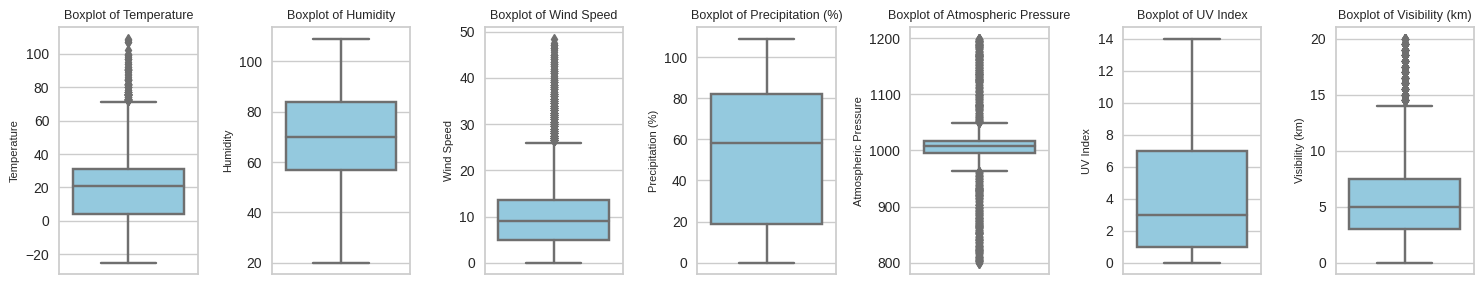

In [538]:
n_cols = 7 
n_rows = math.ceil(len(numeric) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3))
axes = axes.flatten()
for i, col in enumerate(numeric):
    sns.boxplot(data=data, y=col, color="skyblue", ax=axes[i]) 
    axes[i].set_title(f'Boxplot of {col}', fontsize=9)
    axes[i].set_ylabel(col, fontsize=8)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

Qua các boxplot trên, ta có thể đưa ra các nhận xét sau:
1. Temperature: Outlier rõ ràng: Nhiệt độ trên 60°C hoặc dưới -20°C là phi thực tế nên sẽ lọc bỏ các giá trị nằm ngoài khoảng từ -20°C đến 60°C.
2. Humidity: Trong thực tế, độ ẩm tối đa là 100% nên sẽ cắt ngưỡng về khoảng 0 tới 100%.
3. Wind Speed: Tốc độ gió tối đa lên tới 48.5 km/h. Tốc độ này có thể xảy ra trong bão nhưng trên 40 km/h rất hiếm. Vì vậy có thể giữ nguyên nhưng gắn cờ nếu >40.
4. Precipitation (%): Tương tự Humidity, tỷ lệ mưa tối đa là 100% nên sẽ cắt ngưỡng về khoảng 0 tới 100%.
5. Atmospheric Pressure: Giá trị khí quyển thực tế nằm trong khoảng 870hPa tới 1085 hPa nên sẽ cắt ngưỡng về khoảng này.
6. UV Index: Thang UV chuẩn là từ 0 tới 11+ nên có thể giữ lại các giá trị lớn hơn 11.
7. Visibility (km): Không có outlier rõ ràng nên có thể giữ nguyên.

## 3.5 Minh họa heat map và pairplot - Phân tích mối tương quan giữa các biến

### 3.5.1 Minh họa heat map

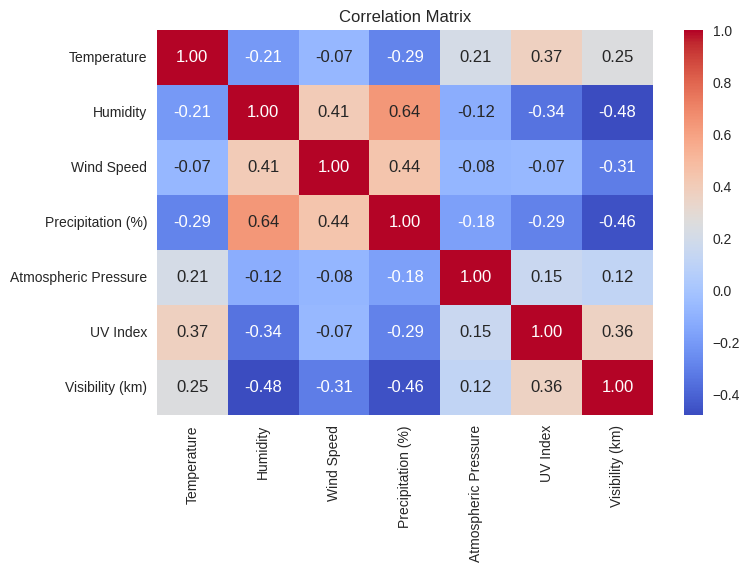

In [539]:
plt.figure(figsize=(8, 5))
corr = data[numeric].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

* Humidity - Precipitation (%): 0.64 → tương quan thuận mạnh → khi độ ẩm tăng, xác suất mưa cũng tăng. => Có thể tổng hợp 2 biến Humidity và Precipitation (%) thành 1 biến mới.
* Humidity - Visibility: -0.48 → tương quan nghịch vừa phải → độ ẩm cao thường làm giảm tầm nhìn.
* Humidity - Wind Speed: 0.41 → Gió mạnh thường xuất hiện trong thời tiết ẩm.
* Precipitation (%) - Visibility: -0.46 → mưa làm giảm tầm nhìn.
* Wind Speed - Precipitation (%): Tương quan thuận nhẹ (0.44) → gió mạnh có thể đi kèm mưa.
* UV Index - Visibility (km): 0.36	Trời quang, UV cao hơn
* UV Index có tương quan thuận với Temperature (0.37) và nghịch với Humidity (-0.34) → trời nắng mạnh hơn thì UV tăng.
=> Không cần bỏ đặc trưng nào.

# 4. Làm sạch và xử lý dữ liệu

## 4.1 Xử lý các giá trị không hợp lệ (outlier)

Xóa bỏ 1417 dòng có chứa giá trị ngoại lệ.

In [540]:
df = data.copy()
initial_count = len(df)
df_filtered = df[(df["Temperature"] <= 60) &(df["Temperature"] >= -20) &(df["Humidity"] <= 100) &(df["Precipitation (%)"] <= 100) &(df["Atmospheric Pressure"] >= 870) &(df["Atmospheric Pressure"] <= 1085)]
filtered_count = len(df_filtered)
removed_count = initial_count - filtered_count
print("Số dòng đã bị lọc:", removed_count)

Số dòng đã bị lọc: 1417


In [541]:
df_filtered.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.00000
mean,18.336502,67.747602,9.419206,50.698379,1004.579433,3.634728,5.33281
std,15.485299,19.092649,6.361297,31.160238,19.939629,3.614014,3.06168
min,-20.000000,20.000000,0.000000,0.000000,870.050000,0.000000,0.00000
25%,4.000000,57.000000,5.000000,18.000000,994.950000,1.000000,3.00000
50%,21.000000,69.000000,8.500000,54.000000,1007.270000,2.000000,5.00000
75%,30.000000,82.000000,13.500000,79.000000,1016.235000,6.000000,7.50000
max,60.000000,100.000000,48.500000,100.000000,1084.820000,14.000000,20.00000


## 4.2 Sinh biến mới

Humidity - Precipitation (%) với hệ số tương quan thuận mạnh 0.64 nên ta sẽ sinh 1 biến tổng hợp 2 biến trên thành 1 biến mới.

In [542]:
df_filtered["Humidity_Precipitation_Combined"] = (df_filtered["Humidity"] + df_filtered["Precipitation (%)"]) / 2

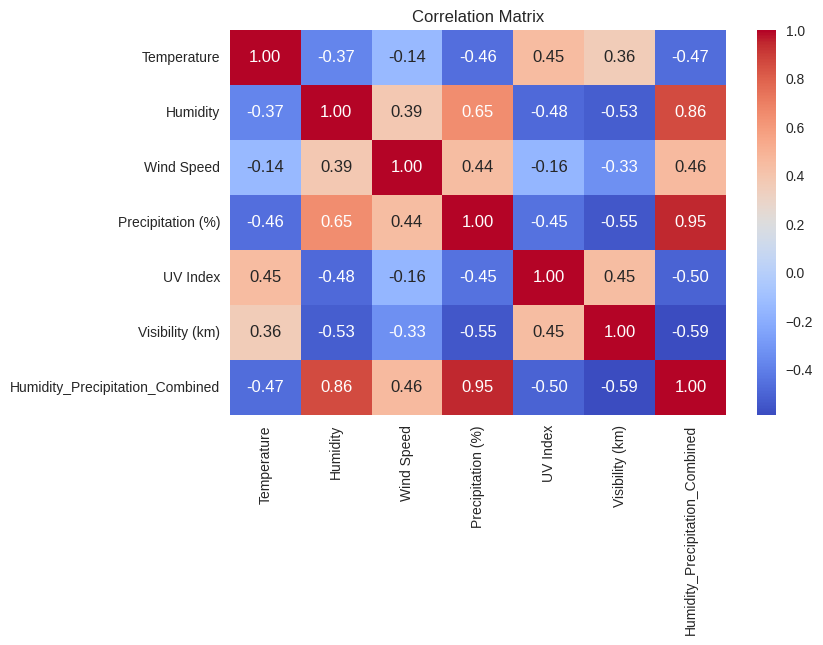

In [543]:
numeric = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'UV Index', 'Visibility (km)', 'Humidity_Precipitation_Combined']
plt.figure(figsize=(8, 5))
corr = df_filtered[numeric].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Biến tổng hợp Humidity_Precipitation_Combined: tương quan rất cao với Precipitation (%): 0.95, tương quan cao với Humidity: 0.86, cũng có tương quan khá với Wind Speed (0.46), ngược với Temperature, UV Index, Visibility (hệ số âm nhẹ đến trung bình).
=> Humidity_Precipitation_Combined đã gom được hầu hết ý nghĩa của cả Humidity và Precipitation. Xóa hai cột gốc Humidity và Precipitation (%) để tránh dư thừa.

In [544]:
df_filtered = df_filtered.drop(['Humidity', 'Precipitation (%)'],axis='columns')

<!-- # Mã hóa one-hot cho các đặc trưng hạng mục -->
## 4.3 Chuyển đặc trưng phân loại (categorical feature) thành đặc trưng số (numerical feature)

* Vì mô hình phân cụm là mô hình học không giám sát nên ta sẽ sử dụng bộ dataset không có nhãn. Ta sẽ xóa cột "Weather Type" - cột nhãn xác định loại thời tiết để không ảnh hưởng đến mô hình phân cụm và sẽ dùng cột này để đánh giá mô hình phân cụm sau này.

In [545]:
df_cleaned = df_filtered.drop(['Weather Type'],axis='columns')

Encoding các biến phân loại (categorical features) bằng One-Hot Encoding sau đó mỗi giá trị phân loại sẽ được chuyển thành một cột nhị phân (0 hoặc 1), giúp mô hình học máy dễ dàng xử lý.

In [546]:
encoder=ce.OneHotEncoder(cols=['Cloud Cover', 'Season', 'Location'], return_df=True,use_cat_names=True)
data_encoded = encoder.fit_transform(df_cleaned)
data_encoded.head()

,Temperature,Wind Speed,Cloud Cover_partly cloudy,Cloud Cover_clear,Cloud Cover_overcast,Cloud Cover_cloudy,Atmospheric Pressure,UV Index,Season_Winter,Season_Spring,Season_Summer,Season_Autumn,Visibility (km),Location_inland,Location_mountain,Location_coastal,Humidity_Precipitation_Combined
0,14.0,9.5,1,0,0,0,1010.82,2,1,0,0,0,3.5,1,0,0,77.5
1,39.0,8.5,1,0,0,0,1011.43,7,0,1,0,0,10.0,1,0,0,83.5
2,30.0,7.0,0,1,0,0,1018.72,5,0,1,0,0,5.5,0,1,0,40.0
3,38.0,1.5,0,1,0,0,1026.25,7,0,1,0,0,1.0,0,0,1,82.5
4,27.0,17.0,0,0,1,0,990.67,1,1,0,0,0,2.5,0,1,0,70.0


Như vậy, các biến phân loại đã được chia thành các cột nhỏ. Các cột này nếu có giá trị là 1 tương ứng với True, 0 tương ứng với False. Cụ thể:
* Cloud Cover được phân thành: Cloud Cover_partly cloudy, Cloud Cover_clear, Cloud Cover_overcast, Cloud Cover_cloudy
* Season được phân thành: Season_Winter, Season_Spring, Season_Summer, Season_Autumn
* Location được phân thành: Location_inland, Location_mountain, Location_coastal

## 4.4 Chuẩn hóa dữ liệu

Như đã nói ở các phần phân tích trước đó, các trường dữ liệu có phân phối lệch nhiều, cần được chuẩn hóa để phân phối bớt lệch hơn. Các đặc trưng số (numeric) sau khi chuẩn hóa, bộ dữ liệu đã có các đặc trưng đồng đều về quy mô và phân phối, với giá trị trung bình gần bằng 0 và độ lệch chuẩn gần 1.

In [547]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric = ['Temperature', 'Wind Speed', 'UV Index', 'Visibility (km)', 'Humidity_Precipitation_Combined']
X_scaled = data_encoded.copy()
X_scaled[numeric] = scaler.fit_transform(data_encoded[numeric])

In [548]:
X_scaled.describe()

,Temperature,Wind Speed,Cloud Cover_partly cloudy,Cloud Cover_clear,Cloud Cover_overcast,Cloud Cover_cloudy,Atmospheric Pressure,UV Index,Season_Winter,Season_Spring,Season_Summer,Season_Autumn,Visibility (km),Location_inland,Location_mountain,Location_coastal,Humidity_Precipitation_Combined
count,1.178300e+04,1.178300e+04,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,1.178300e+04,11783.000000,11783.000000,11783.000000,11783.000000,1.178300e+04,11783.000000,11783.000000,11783.000000,1.178300e+04
mean,-6.633260e-17,-6.512655e-17,0.347789,0.164899,0.468641,0.018671,1004.579433,-7.115679e-17,0.434779,0.194008,0.185946,0.185267,2.140734e-17,0.364933,0.368667,0.266401,1.326652e-17
std,1.000042e+00,1.000042e+00,0.476289,0.371105,0.499037,0.135366,19.939629,1.000042e+00,0.495749,0.395452,0.389079,0.388530,1.000042e+00,0.481432,0.482464,0.442095,1.000042e+00
min,-2.475776e+00,-1.480768e+00,0.000000,0.000000,0.000000,0.000000,870.050000,-1.005774e+00,0.000000,0.000000,0.000000,0.000000,-1.741866e+00,0.000000,0.000000,0.000000,-2.142759e+00
25%,-9.258530e-01,-6.947315e-01,0.000000,0.000000,0.000000,0.000000,994.950000,-7.290618e-01,0.000000,0.000000,0.000000,0.000000,-7.619701e-01,0.000000,0.000000,0.000000,-8.585746e-01
50%,1.720090e-01,-1.445059e-01,0.000000,0.000000,0.000000,0.000000,1007.270000,-4.523495e-01,0.000000,0.000000,0.000000,0.000000,-1.087064e-01,0.000000,0.000000,0.000000,1.426537e-01
75%,7.532301e-01,6.415307e-01,1.000000,0.000000,1.000000,0.000000,1016.235000,6.545000e-01,1.000000,0.000000,0.000000,0.000000,7.078734e-01,1.000000,1.000000,1.000000,8.826920e-01
max,2.690634e+00,6.143787e+00,1.000000,1.000000,1.000000,1.000000,1084.820000,2.868199e+00,1.000000,1.000000,1.000000,1.000000,4.790772e+00,1.000000,1.000000,1.000000,1.753325e+00


# 5. Các mô hình phân cụm thời tiết

## 5.1 Mô hình KMeans

In [549]:
X = X_scaled
inertia_list = []
silhouette_list = []
ch_score_list = []
db_score_list = []
k_range = range(2, 11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=84)
    cluster_labels = kmeans.fit_predict(X)
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X, cluster_labels))
    ch_score_list.append(calinski_harabasz_score(X, cluster_labels))
    db_score_list.append(davies_bouldin_score(X, cluster_labels))

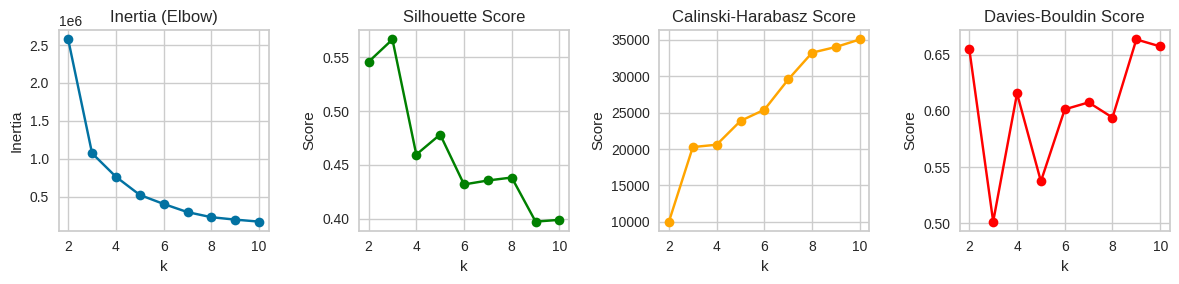

In [550]:
plt.figure(figsize=(12, 3))
# Inertia (Elbow)
plt.subplot(1, 4, 1)
plt.plot(k_range, inertia_list, marker='o')
plt.title("Inertia (Elbow)")
plt.xlabel("k")
plt.ylabel("Inertia")
# Silhouette Score
plt.subplot(1, 4, 2)
plt.plot(k_range, silhouette_list, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
# Calinski-Harabasz Index
plt.subplot(1, 4, 3)
plt.plot(k_range, ch_score_list, marker='o', color='orange')
plt.title("Calinski-Harabasz Score")
plt.xlabel("k")
plt.ylabel("Score")
# Davies-Bouldin Score
plt.subplot(1, 4, 4)
plt.plot(k_range, db_score_list, marker='o', color='red')
plt.title("Davies-Bouldin Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

1. Với biểu đồ khuỷu tay Elbow Method – Inertia: Đường cong Inertia giảm mạnh từ k=2 đến k=4.Khoảng k=5, đường cong bắt đầu "gãy khuỷu" (chậm lại), giảm ít dần.
2. Với Silhouette Score: cao nhất tại k = 3 (khoảng 0.575), k = 2 cũng khá cao khoảng 0.53. Từ k=3 đến k=5 tương đối cao. Sau k=5 thì điểm giảm mạnh.
3. Calinski-Harabasz Score: tăng dần mạnh từ k=2 đến k=8. Từ k=8 trở đi, mức tăng dần chậm lại.
4. Davies-Bouldin Score: thấp nhất ở k=3 và k=5 (~0.53). Giá trị nhỏ nhất rõ rệt tại k=3 nhưng k=5 cũng khá thấp.

**Kết luận:** Chọn k = 5 cho mô hình KMeans.

In [551]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

## 5.2 Mô hình DBSCAN

In [552]:
from sklearn.metrics import silhouette_score
best_eps = None
best_score = -1
for eps in np.arange(0.2, 5.0, 0.2):
    db = DBSCAN(eps=eps, min_samples=11)
    labels = db.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_eps = eps
print(f"Best eps: {best_eps}, Silhouette: {best_score:.4f}")

Best eps: 3.6000000000000005, Silhouette: 0.6958


In [553]:
dbscan = DBSCAN(eps=3.6, min_samples=11)
dbscan_labels = dbscan.fit_predict(X)

## 5.3 Agglomerative Clustering

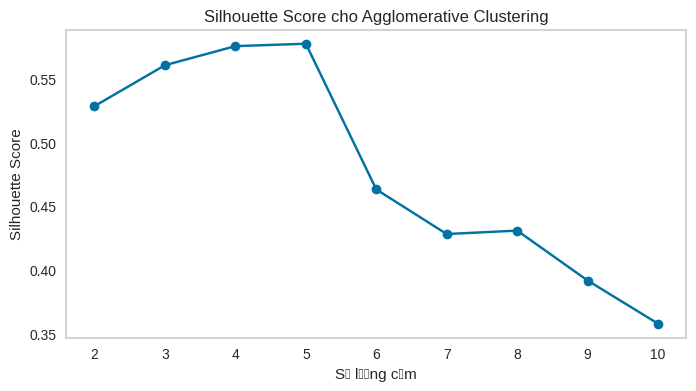

In [554]:
silhouette_scores = []
for n in range(2, 11):
    agglo = AgglomerativeClustering(n_clusters=n)
    labels = agglo.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Score cho Agglomerative Clustering")
plt.xlabel("Số lượng cụm")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

Với k=4 hoặc k=5 thì Silhouette Score khá cao khoảng 0.57 => Chọn k=5.

In [555]:
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(X)

# 6. Trực quan hóa kết quả phân cụm bằng PCA

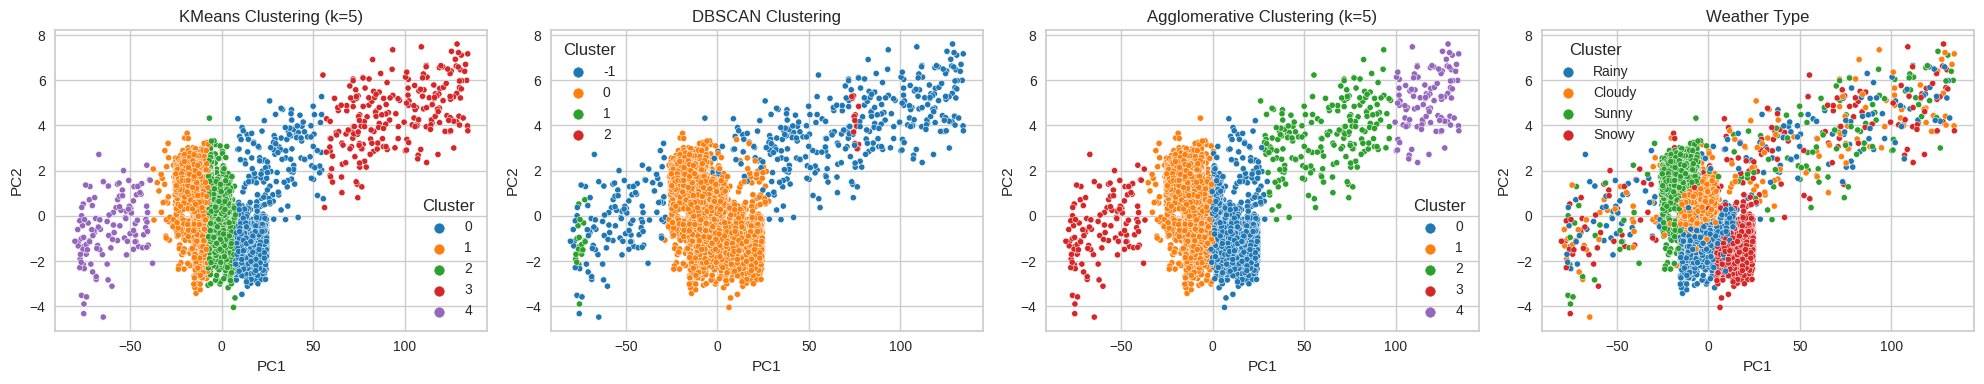

In [556]:
true_labels = df_filtered['Weather Type']
def plot_pca_clusters_subplot(X, labels, title, ax):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    df_plot = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'Cluster': labels})
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Cluster',
                    palette='tab10', s=20, ax=ax, legend=True)
    ax.set_title(title)
clusterings = [
    (kmeans_labels, "KMeans Clustering (k=5)"),
    (dbscan_labels, "DBSCAN Clustering"),
    (agg_labels, "Agglomerative Clustering (k=5)"),
    (true_labels, "Weather Type")
]
fig, axes = plt.subplots(1, len(clusterings), figsize=(20, 4)) 
for i, (labels, title) in enumerate(clusterings):
    plot_pca_clusters_subplot(X, labels, title, axes[i])
plt.tight_layout()
plt.show()

- **KMeans:** Các cụm tách khá rõ theo trục PC1 nhưng chủ yếu chia theo giá trị PC1 thay vì thật sự nhóm tự nhiên, nhóm hơi "cứng", bị ép chia đều không linh hoạt.
- **DBSCAN:** Phát hiện được một cụm lớn và vài cụm nhỏ, nhiều điểm noise (-1).
- **Agglomerative:** Phân cụm rất rõ, sát với dạng phân bố tự nhiên, rõ từng cụm tách biệt, khá giống với nhãn Weather Type.

# 7. So sánh và đánh giá các mô hình phân cụm thời tiết

## 7.1 Biểu đồ Silhouette

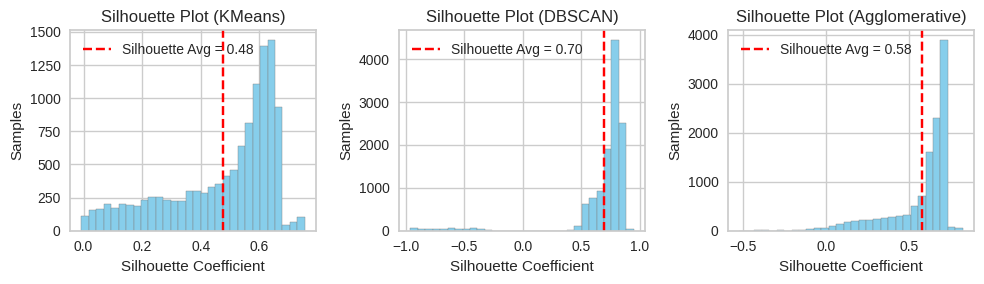

In [557]:
def plot_silhouette_scores(X_scaled, labels, model_name, ax):
    sil_vals = silhouette_samples(X_scaled, labels)
    sil_avg = silhouette_score(X_scaled, labels)
    ax.hist(sil_vals, bins=30, color='skyblue', edgecolor='gray')
    ax.axvline(sil_avg, color='red', linestyle='--', label=f"Silhouette Avg = {sil_avg:.2f}")
    ax.set_title(f"Silhouette Plot ({model_name})")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Samples")
    ax.legend()
    ax.grid(True)
fig, axes = plt.subplots(1, 3, figsize=(10, 3)) 
plot_silhouette_scores(X_scaled, kmeans_labels, "KMeans", axes[0])
plot_silhouette_scores(X_scaled, dbscan_labels, "DBSCAN", axes[1])
plot_silhouette_scores(X_scaled, agg_labels, "Agglomerative", axes[2])
plt.tight_layout()
plt.show()

- **KMeans**: Phân cụm tốt, ít nhiễu, trung bình silhouette ≈ 0.48, đa số điểm chất lượng tốt.
- **DBSCAN**: Phân cụm tự nhiên, loại noise, silhouette trung bình ~0.70, đa số điểm > 0.6, ít điểm biên.
- **Agglomerative**: Phân tách ổn, silhouette trung bình ≈ 0.58, nhiều điểm > 0.5 nhưng vẫn có chồng lấn nhẹ, ít điểm sai cụm. Cụm rõ ràng nhất chiếm đa số.

## 7.2 Các chỉ số đánh giá mô hình phân cụm

1. **Silhouette Score**: Đo độ "chặt chẽ" và phân biệt nhóm, từ -1 (sai nhóm) đến 1 (chặt chẽ, phân biệt rõ).
2. **Inertia (K-Means)**: Đo độ gần của điểm với tâm cụm, giá trị thấp là tốt.
3. **Davies-Bouldin Index**: Đánh giá chất lượng phân cụm, giá trị thấp là tốt.
4. **Adjust Rand Index (ARI)**: So sánh phân cụm với nhãn thực tế, từ -1 (ngược chiều) đến 1 (hoàn toàn giống).

In [558]:
def collect_scores(X, labels, model_name):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ari = adjusted_rand_score(true_labels, labels)
    return {
        'Model': model_name,
        'Silhouette Score': round(sil, 4),
        'Calinski-Harabasz': round(ch, 2),
        'Davies-Bouldin': round(db, 4),
        'Adjusted Rand Index': round(ari, 4)
    }
results = []
results.append(collect_scores(X, kmeans_labels, "KMeans"))

if len(set(dbscan_labels)) > 1:
    results.append(collect_scores(X, dbscan_labels, "DBSCAN"))
else:
    print("DBSCAN không tạo ra đủ cụm hợp lệ để đánh giá.")
results.append(collect_scores(X, agg_labels, "Agglomerative"))
results.append(collect_scores(X, gmm_labels, "GaussianMixture"))
# In bảng kết quả
results_df = pd.DataFrame(results)
results_df

,Model,Silhouette Score,Calinski-Harabasz,Davies-Bouldin,Adjusted Rand Index
0,KMeans,0.4779,23869.05,0.5377,0.3015
1,DBSCAN,0.6958,942.07,1.3419,-0.0000
2,Agglomerative,0.5774,17583.03,0.5015,0.2536
3,GaussianMixture,0.0338,1221.62,4.3538,0.3036


* KMeans: Silhouette khá ổn; Calinski-Harabasz rất cao → cụm phân tách rất tốt; Davies-Bouldin mức khá; phân cụm có độ chính xác tương đối.
* DBSCAN: Silhouette rất cao, tách cụm rất tốt; Calinski-Harabasz thấp → không mạnh về độ tách biệt giữa các cụm; Davies-Bouldin cao → không lý tưởng, cụm không đồng đều; không khớp nhiều với nhãn thực tế.
* Agglomerative Clustering: Silhouette tốt; Calinski-Harabasz rất cao, tốt hơn DBSCAN, kém KMeans chút; Davies-Bouldin tốt nhất trong các mô hình; ARI = 0.2536 → ổn định.

=> Kết luận: Lựa chọn mô hình **Agglomerative Clustering**

# 8. Định nghĩa từng cụm theo mô hình được chọn

In [559]:
df_filtered['cluster'] = agg_labels
for cluster_label in sorted(df_filtered['cluster'].unique()):
    print(f"\nThống kê cụm {cluster_label}")
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_label]
    stats = cluster_data.describe().loc[['mean', '50%', 'std']]
    stats.rename(index={'50%': 'median'}, inplace=True)
    display(stats)


Thống kê cụm 0


,Temperature,Wind Speed,Atmospheric Pressure,UV Index,Visibility (km),Humidity_Precipitation_Combined,cluster
mean,8.023928,11.157228,993.862584,1.654038,3.651047,73.712961,0.0
median,3.000000,10.500000,994.380000,1.000000,3.500000,76.500000,0.0
std,14.470422,6.777775,6.941261,2.460245,2.219274,14.144054,0.0



Thống kê cụm 1


,Temperature,Wind Speed,Atmospheric Pressure,UV Index,Visibility (km),Humidity_Precipitation_Combined,cluster
mean,26.714872,8.176034,1015.845868,4.960530,6.337307,48.162614,1.0
median,27.000000,7.500000,1015.270000,4.000000,6.500000,43.500000,1.0
std,9.811689,5.782408,6.422406,3.540346,2.504097,22.689401,0.0



Thống kê cụm 2


,Temperature,Wind Speed,Atmospheric Pressure,UV Index,Visibility (km),Humidity_Precipitation_Combined,cluster
mean,16.946341,7.836585,942.401610,6.960976,10.707317,53.153659,2.0
median,19.000000,8.000000,939.180000,7.000000,11.500000,54.500000,2.0
std,21.473240,4.445628,20.177438,4.294141,6.037034,15.927287,0.0



Thống kê cụm 3


,Temperature,Wind Speed,Atmospheric Pressure,UV Index,Visibility (km),Humidity_Precipitation_Combined,cluster
mean,14.612903,7.048387,1064.690645,7.419355,9.935484,52.576613,3.0
median,13.500000,6.500000,1064.890000,8.000000,10.500000,50.500000,3.0
std,19.745828,4.339935,12.892108,4.128223,5.980989,16.304900,0.0



Thống kê cụm 4


,Temperature,Wind Speed,Atmospheric Pressure,UV Index,Visibility (km),Humidity_Precipitation_Combined,cluster
mean,12.580952,7.290476,887.208571,7.295238,9.133333,54.057143,4.0
median,11.000000,7.500000,886.600000,8.000000,8.500000,56.500000,4.0
std,19.636985,4.058337,10.308570,4.430931,5.852459,15.959280,0.0


Qua các thống kê của từng cụm, ta có thể đưa ra nhận xét về các cụm thời tiết như sau:
1. Cụm 0: Nhiệt độ thấp, độ ẩm cao, tốc độ gió trung bình mạnh, tầm nhìn kém, chỉ số UV rất thấp. => Đặc trưng: Lạnh, ẩm cao, nhiều mưa, tối tăm
2. Cụm 1: Nhiệt độ cao, độ ẩm trung bình, gió nhẹ hơn, chỉ số UV trung bình cao, tầm nhìn khá. => Đặc trưng: Ấm áp, ẩm nhẹ, ít mưa, trời sáng
3. Cụm 2: Nhiệt độ trung bình thấp, độ ấm khá thấp, tỉ lệ mưa cao, chỉ số UV cao, tầm nhìn tốt. => Đặc trưng: Mát, khô nhẹ, mưa nhiều, trời sáng
4. Cụm 3: Nhiệt độ trung bình thấp, độ ẩm thấp, mưa trung bình, chỉ số UV cao, tầm nhìn tốt. => Đặc trưng: Mát, khô, mưa trung bình, UV cao
5. Cụm 4: Nhiệt độ thấp, độ ẩm thấp, mưa nhiều, chỉ số UV cao, tầm nhìn tốt. => Đặc trưng: Lạnh, rất khô, mưa nhiều, trời sáng

In [560]:
df_clustered['Cluster'].value_counts()

Cluster
1    6334
0    5015
2     205
3     124
4     105
Name: count, dtype: int64

* Cụm 1 và 2 chiếm đa số (~67%): dữ liệu chủ yếu là thời tiết ấm áp đến mát mẻ, không quá cực đoan.
* Cụm 0 cũng khá lớn (~26%): đại diện cho thời tiết lạnh, ẩm thấp, nhiều mưa — có thể là mùa đông hoặc những ngày mưa dài.
* Cụm 3 và 4 rất nhỏ (chỉ ~3% tổng số liệu) là những điều kiện đặc biệt hơn: cực khô hoặc UV cực cao, khí áp khác biệt.

In [561]:
cluster_names = {
0: 'Lạnh, ẩm cao, nhiều mưa, tối tăm',
1:	'Ấm áp, ẩm nhẹ, ít mưa, trời sáng',
2:	'Mát, khô nhẹ, mưa nhiều, trời sáng',
3:	'Mát, khô, mưa trung bình, UV cao',
4:	'Lạnh, rất khô, mưa nhiều, trời sáng'
}
for cluster in range(5):
    print(f"\n🔹 Một vài mẫu cụm {cluster} - {cluster_names[cluster]}")
    display(df_clustered[df_clustered['Cluster'] == cluster].sample(3))


🔹 Một vài mẫu cụm 0 - Lạnh, ẩm cao, nhiều mưa, tối tăm


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Cluster
6777,30.0,73,17.5,52.0,overcast,995.78,1,Summer,1.0,mountain,Rainy,0
7209,-7.0,82,4.5,90.0,overcast,999.26,0,Winter,2.5,inland,Snowy,0
6245,-2.0,68,16.0,99.0,partly cloudy,994.22,1,Winter,1.0,inland,Snowy,0



🔹 Một vài mẫu cụm 1 - Ấm áp, ẩm nhẹ, ít mưa, trời sáng


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Cluster
5550,35.0,48,4.5,4.0,clear,1024.97,8,Summer,5.0,coastal,Sunny,1
8423,24.0,92,7.0,67.0,overcast,1014.99,3,Winter,4.5,mountain,Rainy,1
2051,23.0,64,3.0,35.0,partly cloudy,1007.27,1,Winter,5.5,mountain,Cloudy,1



🔹 Một vài mẫu cụm 2 - Mát, khô nhẹ, mưa nhiều, trời sáng


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Cluster
9312,28.0,68,5.5,67.0,partly cloudy,932.32,2,Spring,11.5,coastal,Cloudy,2
5512,34.0,70,6.0,69.0,cloudy,922.46,3,Summer,6.0,coastal,Snowy,2
12863,-17.0,37,14.0,34.0,cloudy,912.53,10,Summer,16.5,inland,Rainy,2



🔹 Một vài mẫu cụm 3 - Mát, khô, mưa trung bình, UV cao


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Cluster
7217,16.0,69,4.5,31.0,partly cloudy,1041.60,0,Spring,11.0,inland,Snowy,3
8696,-1.0,54,10.0,99.0,partly cloudy,1080.07,0,Summer,1.0,mountain,Snowy,3
4798,20.0,55,4.5,21.0,cloudy,1074.96,4,Summer,8.0,coastal,Rainy,3



🔹 Một vài mẫu cụm 4 - Lạnh, rất khô, mưa nhiều, trời sáng


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Cluster
9491,7.0,60,2.5,85.0,partly cloudy,877.83,2,Spring,7.0,mountain,Rainy,4
2107,11.0,68,3.5,31.0,partly cloudy,902.53,8,Winter,9.0,coastal,Cloudy,4
1885,13.0,60,10.5,76.0,partly cloudy,881.44,12,Summer,3.0,inland,Cloudy,4


In [ ]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
name = 'Data science BTL'
export_notebook(f"{name}.ipynb", filtering=True, pagebreaks=True)
if(path.exists(f'{name}.pdf')):
    display(HTML(f"Download your PDF <a href='{name}.pdf' download>here</a>."))
else:
    print("\n Pdf generation failed, please try the other methods described above")